
# 📘 Experiment Log : Assignment 1 - two_layer_net.ipynb

- 🗓️ 과제 수행일: 2025.04.05 ~ 2025.04.06
- ⏱️ 정리일: 2025.04.06
- 🧠 목적: 2층 신경망 구현 및 하이퍼파라미터 튜닝

---

## 1. 📂 Dataset & Task
- 사용한 데이터셋: CIFAR-10
- Task 유형: 분류
- Input 형태: 이미지(32x32)
- Output 형태: 클래스 라벨

---

## 2. 🧪 실험 내용 요약
- 모델 구조: Two-Layer Net ( Affine - Relu - Affine - Softmax )
- Loss 함수: Cross-Entropy
- 실험 과정 :
 - Step 1: hidden_size는 50으로 고정하고, 최대한 넓은 범위에서 lr, reg에 대해 초기 탐색 (grid search)

 - Step 2: 범위 재설정 후 하이퍼파리미터 재탐색 (random search)

 - Step 3: SGD → Adam 변경 후 하이퍼파리미터 재탐색 (random search)

 - Step 4: Fine tuning - best 조합 근처에서 조밀한 grid search 수행

 - Step 5: hidden_size 조정 및 최종 모델 결정

---

## 3. 📊 실험 결과

- **Best Hyperparameter Configuration**

 - hidden_size: 200  
 - learning rate: 7e-5
 - regularization strength: 5e-3  

- **Validation Accuracy : 0.539**
---

## 4. 🔍 해석 및 인사이트

- 하이퍼파라미터 튜닝은 넓은 범위부터 탐색을 시작하여 이후 성능이 좋은 구간을 중심으로 범위를 줄여나가는 방식으로 수행함.
- Adam은 작은 학습률에서도 비교적 잘 작동함 → SGD에 비해 더 안정적인 결과를 낼 수 있음.  

- 💡 INSIGHT:
 - itertools.product 를 사용하면 다중 반복문을 피할 수 있음.
 - uniform(5e-5, 5e-3)과 5 * 10 ** uniform(-5,-3)의 차이 : 균등한 스케일이 다름 (선형 vs 로그)

---

## 5. 💬 한 줄 회고
- CS231n 6, 7강 : `Training Neural Networks I & II` 에서 배운 내용을 참고하여 하이퍼파라미터 튜닝을 진행했다. 이렇게 체계적으로 하이퍼파라미터 튜닝을 진행한 건 처음인데 하이퍼파라미터 튜닝이 어떤 흐름으로 진행되는지 직접 실습해보며 익힐 수 있었다. 성능을 더 향상시키려면 ensemble을 활용하거나 `hidden_size = 200`에 대해서 더 큰 regularization strength를 탐색해볼 수도 있을 것 같다.
---



In [2]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'Colab_Notebooks/cs231n/cs231n_assignment1/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/Colab_Notebooks/cs231n/cs231n_assignment1/cs231n/datasets
/content/drive/My Drive/Colab_Notebooks/cs231n/cs231n_assignment1


# Fully-Connected Neural Nets
In this exercise we will implement fully-connected networks using a modular approach. For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive dout (derivative of loss with respect to outputs) and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.
  

In [3]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [4]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in list(data.items()):
  print(('%s: ' % k, v.shape))

('X_train: ', (49000, 3, 32, 32))
('y_train: ', (49000,))
('X_val: ', (1000, 3, 32, 32))
('y_val: ', (1000,))
('X_test: ', (1000, 3, 32, 32))
('y_test: ', (1000,))


# Affine layer: forward
Open the file `cs231n/layers.py` and implement the `affine_forward` function.

Once you are done you can test your implementaion by running the following:

In [5]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around e-9 or less.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  9.769849468192957e-10


# Affine layer: backward
Now implement the `affine_backward` function and test your implementation using numeric gradient checking.

In [6]:
# Test the affine_backward function
np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around e-10 or less
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  5.399100368651805e-11
dw error:  9.904211865398145e-11
db error:  2.4122867568119087e-11


# ReLU activation: forward
Implement the forward pass for the ReLU activation function in the `relu_forward` function and test your implementation using the following:

In [7]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be on the order of e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.999999798022158e-08


# ReLU activation: backward
Now implement the backward pass for the ReLU activation function in the `relu_backward` function and test your implementation using numeric gradient checking:

In [8]:
np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be on the order of e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.2756349136310288e-12


## Inline Question 1:

We've only asked you to implement ReLU, but there are a number of different activation functions that one could use in neural networks, each with its pros and cons. In particular, an issue commonly seen with activation functions is getting zero (or close to zero) gradient flow during backpropagation. Which of the following activation functions have this problem? If you consider these functions in the one dimensional case, what types of input would lead to this behaviour?
1. Sigmoid
2. ReLU
3. Leaky ReLU

## Answer: Sigmoid & ReLU.  
Sigmoid는 아주 크거나 아주 작은 입력값에서는 기울기가 0에 가까워진다. ReLU 에서는 입력값이 0보다 작을 땐 기울기가 0이 되어버린다.



# "Sandwich" layers
There are some common patterns of layers that are frequently used in neural nets. For example, affine layers are frequently followed by a ReLU nonlinearity. To make these common patterns easy, we define several convenience layers in the file `cs231n/layer_utils.py`.

For now take a look at the `affine_relu_forward` and `affine_relu_backward` functions, and run the following to numerically gradient check the backward pass:

In [9]:
from cs231n.layer_utils import affine_relu_forward, affine_relu_backward
np.random.seed(231)
x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

# Relative error should be around e-10 or less
print('Testing affine_relu_forward and affine_relu_backward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_relu_forward and affine_relu_backward:
dx error:  2.299579177309368e-11
dw error:  8.162011105764925e-11
db error:  7.826724021458994e-12


# Loss layers: Softmax and SVM
Now implement the loss and gradient for softmax and SVM in the `softmax_loss` and `svm_loss` function in `cs231n/layers.py`. These should be similar to what you implemented in `cs231n/classifiers/softmax.py` and `cs231n/classifiers/linear_svm.py`.

You can make sure that the implementations are correct by running the following:

In [10]:
np.random.seed(231)
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: svm_loss(x, y)[0], x, verbose=False)
loss, dx = svm_loss(x, y)

# Test svm_loss function. Loss should be around 9 and dx error should be around the order of e-9
print('Testing svm_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be close to 2.3 and dx error should be around e-8
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

Testing svm_loss:
loss:  8.999602749096233
dx error:  1.4021566006651672e-09

Testing softmax_loss:
loss:  2.302545844500738
dx error:  9.483503037636722e-09


# Two-layer network
Open the file `cs231n/classifiers/fc_net.py` and complete the implementation of the `TwoLayerNet` class. Read through it to make sure you understand the API. You can run the cell below to test your implementation.

In [11]:
np.random.seed(231)
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-3
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

# Errors should be around e-7 or less
for reg in [0.0, 0.7]:
  print('Running numeric gradient check with reg = ', reg)
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0
W1 relative error: 1.83e-08
W2 relative error: 3.31e-10
b1 relative error: 9.83e-09
b2 relative error: 4.33e-10
Running numeric gradient check with reg =  0.7
W1 relative error: 2.53e-07
W2 relative error: 2.85e-08
b1 relative error: 1.56e-08
b2 relative error: 7.76e-10


# Solver
Open the file `cs231n/solver.py` and read through it to familiarize yourself with the API. After doing so, use a `Solver` instance to train a `TwoLayerNet` that achieves about `36%` accuracy on the validation set.

In [12]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
model = TwoLayerNet(input_size, hidden_size, num_classes)
solver = None

##############################################################################
# TODO: Use a Solver instance to train a TwoLayerNet that achieves about 36% #
# accuracy on the validation set.                                            #
##############################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

solver = Solver(
    model, data,
    update_rule = 'sgd',
    optim_config = {
        'learning_rate': 1e-4
    },
    num_epochs = 5, batch_size = 200,
    print_every = 100
    )

solver.train()

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

(Iteration 1 / 1225) loss: 2.301725
(Epoch 0 / 5) train acc: 0.145000; val_acc: 0.140000
(Iteration 101 / 1225) loss: 2.241923
(Iteration 201 / 1225) loss: 2.187425
(Epoch 1 / 5) train acc: 0.267000; val_acc: 0.243000
(Iteration 301 / 1225) loss: 2.054664
(Iteration 401 / 1225) loss: 1.933512
(Epoch 2 / 5) train acc: 0.297000; val_acc: 0.297000
(Iteration 501 / 1225) loss: 1.919245
(Iteration 601 / 1225) loss: 1.925960
(Iteration 701 / 1225) loss: 1.824556
(Epoch 3 / 5) train acc: 0.341000; val_acc: 0.317000
(Iteration 801 / 1225) loss: 1.948588
(Iteration 901 / 1225) loss: 1.817925
(Epoch 4 / 5) train acc: 0.347000; val_acc: 0.364000
(Iteration 1001 / 1225) loss: 1.721173
(Iteration 1101 / 1225) loss: 1.923569
(Iteration 1201 / 1225) loss: 1.835021
(Epoch 5 / 5) train acc: 0.363000; val_acc: 0.380000


# Debug the training
With the default parameters we provided above, you should get a validation accuracy of about 0.36 on the validation set. This isn't very good.

One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization.

Another strategy is to visualize the weights that were learned in the first layer of the network. In most neural networks trained on visual data, the first layer weights typically show some visible structure when visualized.

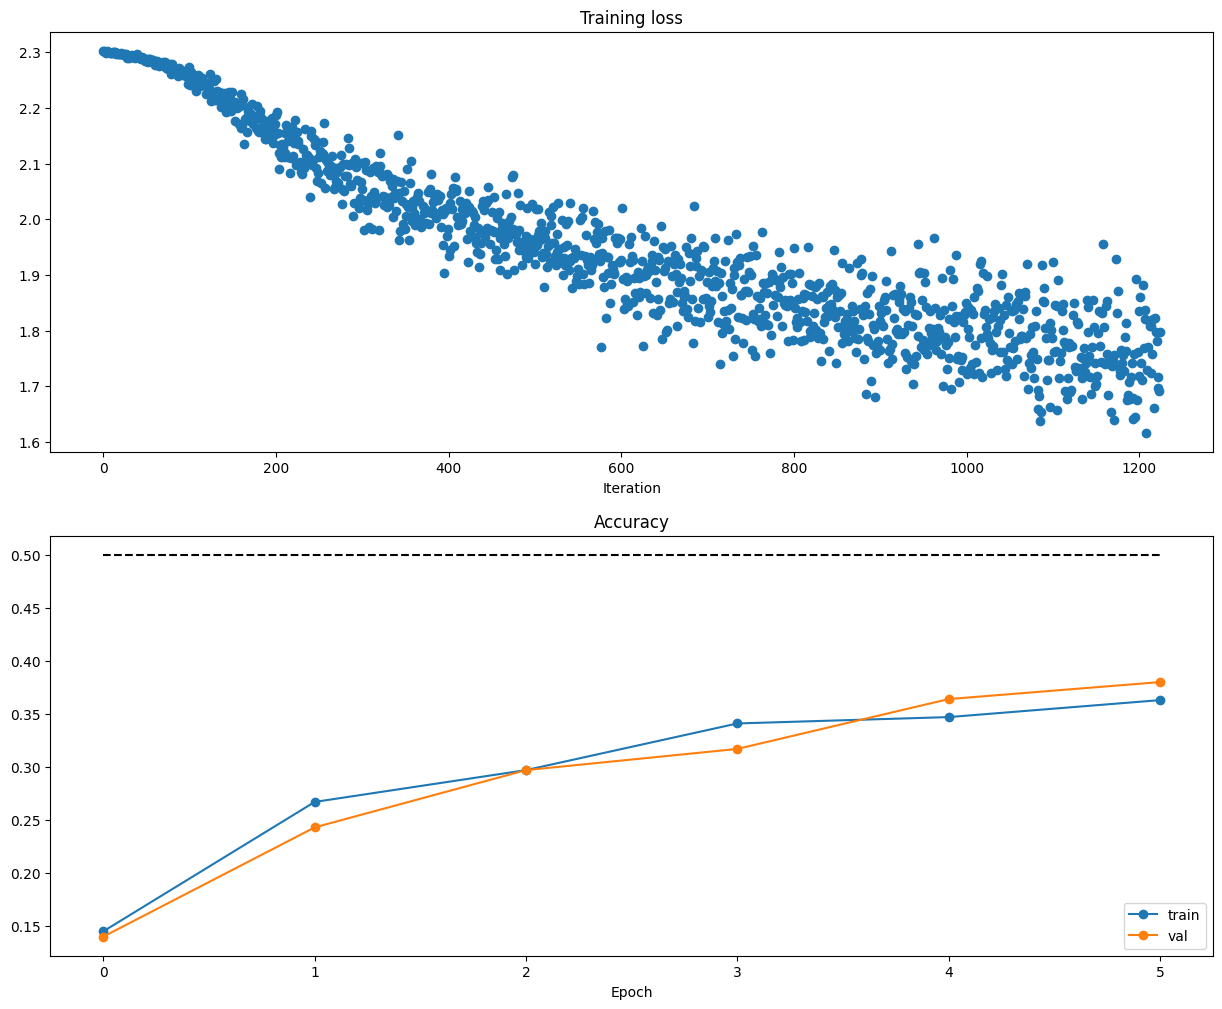

In [13]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

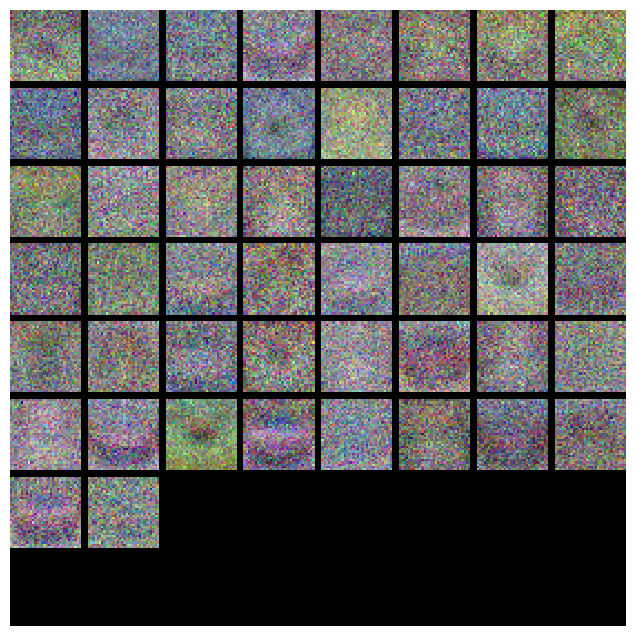

In [14]:
from cs231n.vis_utils import visualize_grid

# Visualize the weights of the network

def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.reshape(3, 32, 32, -1).transpose(3, 1, 2, 0)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(model)

# Tune your hyperparameters

**What's wrong?**. Looking at the visualizations above, we see that the loss is decreasing more or less linearly, which seems to suggest that the learning rate may be too low. Moreover, there is no gap between the training and validation accuracy, suggesting that the model we used has low capacity, and that we should increase its size. On the other hand, with a very large model we would expect to see more overfitting, which would manifest itself as a very large gap between the training and validation accuracy.

**Tuning**. Tuning the hyperparameters and developing intuition for how they affect the final performance is a large part of using Neural Networks, so we want you to get a lot of practice. Below, you should experiment with different values of the various hyperparameters, including hidden layer size, learning rate, numer of training epochs, and regularization strength. You might also consider tuning the learning rate decay, but you should be able to get good performance using the default value.

**Approximate results**. You should be aim to achieve a classification accuracy of greater than 48% on the validation set. Our best network gets over 52% on the validation set.

**Experiment**: You goal in this exercise is to get as good of a result on CIFAR-10 as you can (52% could serve as a reference), with a fully-connected Neural Network. Feel free implement your own techniques (e.g. PCA to reduce dimensionality, or adding dropout, or adding features to the solver, etc.).

 ## 🎯 Step 1: hidden_size는 50으로 고정하고, 최대한 넓은 범위에서 lr, reg에 대해 초기 탐색 (grid search)
 - **hidden_sizes** = [50]  
 - **lrs** = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
 - **regs** = [1e-5, 1e-3, 1e-1, 1e1, 1e3, 1e5]
 - **num_epochs** = 3, **batch_size** = 400



---


💡 INSIGHT:  

- 처음엔 3중 반복문을 사용 했었음. (hidden_size, lr, reg 각각에 대해 반복문)
- 깔끔하지 않고 가독성도 떨어질 것 같아서 3중 반복문을 피할 수 있는 방법 없는지 찾아봄
- itertools의 product 라는게 있다는 걸 알게 됨. 보다 깔끔하게 코드 작성 가능.

In [38]:
from itertools import product # 3중 반복문을 피하기 위해 product 활용.
best_model = None
input_size = 32 * 32 * 3
num_classes = 10

#################################################################################
# TODO: Tune hyperparameters using the validation set. Store your best trained  #
# model in best_model.                                                          #
#                                                                               #
# To help debug your network, it may help to use visualizations similar to the  #
# ones we used above; these visualizations will have significant qualitative    #
# differences from the ones we saw above for the poorly tuned network.          #
#                                                                               #
# Tweaking hyperparameters by hand can be fun, but you might find it useful to  #
# write code to sweep through possible combinations of hyperparameters          #
# automatically like we did on thexs previous exercises.                        #
#################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

results1 = []
best_val = -1
hidden_sizes = [50]
lrs = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2] # learning_rates
regs = [1e-5, 1e-3, 1e-1, 1e1, 1e3, 1e5] # regularization_strengths

count = 0
for hidden_size, lr, reg in product(hidden_sizes, lrs, regs):
    val_model = TwoLayerNet(input_size, hidden_size, num_classes, reg=reg)
    solver = Solver(
    val_model, data,
    update_rule = 'sgd',
    optim_config = {
        'learning_rate': lr
    },
    num_epochs = 3, batch_size = 400,
    print_every = 1000,
    verbose = False
    )
    solver.train()

    results1.append(
        {
            'hidden_size' : hidden_size,
            'learning_rate' : lr,
            'regularization_strengths' : reg,
            # NOTE: best_val_acc 일 때의 train_acc를 구해서 기록.
            'train_acc' : solver.check_accuracy(data['X_train'], data['y_train']),
            'val_acc' : solver.best_val_acc
        }
    )
    count += 1
    # 결과 출력
    print(f"{count}/{len(hidden_sizes) * len(lrs) * len(regs)} : "
        + f"hidden_size = {hidden_size}, lr = {lr}, reg = {reg}, "
        + f"train_acc = {results1[count-1]['train_acc']}, "
        + f"val_acc = {results1[count-1]['val_acc']}")


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

1/36 : hidden_size = 50, lr = 1e-07, reg = 1e-05, train_acc = 0.1056734693877551, val_acc = 0.12
2/36 : hidden_size = 50, lr = 1e-07, reg = 0.001, train_acc = 0.12477551020408163, val_acc = 0.143
3/36 : hidden_size = 50, lr = 1e-07, reg = 0.1, train_acc = 0.10083673469387755, val_acc = 0.093
4/36 : hidden_size = 50, lr = 1e-07, reg = 10.0, train_acc = 0.08973469387755102, val_acc = 0.102
5/36 : hidden_size = 50, lr = 1e-07, reg = 1000.0, train_acc = 0.08971428571428572, val_acc = 0.098
6/36 : hidden_size = 50, lr = 1e-07, reg = 100000.0, train_acc = 0.0803265306122449, val_acc = 0.072
7/36 : hidden_size = 50, lr = 1e-06, reg = 1e-05, train_acc = 0.09255102040816326, val_acc = 0.077
8/36 : hidden_size = 50, lr = 1e-06, reg = 0.001, train_acc = 0.13481632653061223, val_acc = 0.116
9/36 : hidden_size = 50, lr = 1e-06, reg = 0.1, train_acc = 0.12155102040816326, val_acc = 0.123
10/36 : hidden_size = 50, lr = 1e-06, reg = 10.0, train_acc = 0.11987755102040816, val_acc = 0.12
11/36 : hidden_

/content/drive/My Drive/Colab_Notebooks/cs231n/cs231n_assignment1/cs231n/layers.py:826: RuntimeWarning: overflow encountered in exp
  x = np.exp(x)
/content/drive/My Drive/Colab_Notebooks/cs231n/cs231n_assignment1/cs231n/layers.py:828: RuntimeWarning: invalid value encountered in divide
  loss -= np.sum(np.log(x[np.arange(N), y] / s_sum))
/content/drive/My Drive/Colab_Notebooks/cs231n/cs231n_assignment1/cs231n/layers.py:828: RuntimeWarning: divide by zero encountered in log
  loss -= np.sum(np.log(x[np.arange(N), y] / s_sum))
/content/drive/My Drive/Colab_Notebooks/cs231n/cs231n_assignment1/cs231n/layers.py:830: RuntimeWarning: invalid value encountered in divide
  dx = x / s_sum.reshape(-1,1)


24/36 : hidden_size = 50, lr = 0.0001, reg = 100000.0, train_acc = 0.10026530612244898, val_acc = 0.087
25/36 : hidden_size = 50, lr = 0.001, reg = 1e-05, train_acc = 0.45624489795918366, val_acc = 0.459
26/36 : hidden_size = 50, lr = 0.001, reg = 0.001, train_acc = 0.4479591836734694, val_acc = 0.456
27/36 : hidden_size = 50, lr = 0.001, reg = 0.1, train_acc = 0.454265306122449, val_acc = 0.452
28/36 : hidden_size = 50, lr = 0.001, reg = 10.0, train_acc = 0.38155102040816324, val_acc = 0.384
29/36 : hidden_size = 50, lr = 0.001, reg = 1000.0, train_acc = 0.10004081632653061, val_acc = 0.098
30/36 : hidden_size = 50, lr = 0.001, reg = 100000.0, train_acc = 0.10026530612244898, val_acc = 0.087
31/36 : hidden_size = 50, lr = 0.01, reg = 1e-05, train_acc = 0.2014081632653061, val_acc = 0.201
32/36 : hidden_size = 50, lr = 0.01, reg = 0.001, train_acc = 0.16240816326530613, val_acc = 0.145
33/36 : hidden_size = 50, lr = 0.01, reg = 0.1, train_acc = 0.19191836734693876, val_acc = 0.205
34/3

In [42]:
# pandas 를 활용하여 결과를 표로 정리
import pandas as pd

df1 = pd.DataFrame(results1)
df1 = df1.sort_values(by='learning_rate', ascending=True)
df1 = df1.style.format({
    'learning_rate': '{:.3e}',
    'regularization_strengths': '{:.3e}',
    'train_acc': '{:.3f}',
    'val_acc': '{:.3f}'
})
display(df1)

,hidden_size,learning_rate,regularization_strengths,train_acc,val_acc
0,50,1.000e-07,1.000e-05,0.106,0.120
1,50,1.000e-07,1.000e-03,0.125,0.143
2,50,1.000e-07,1.000e-01,0.101,0.093
3,50,1.000e-07,1.000e+01,0.090,0.102
4,50,1.000e-07,1.000e+03,0.090,0.098
5,50,1.000e-07,1.000e+05,0.080,0.072
6,50,1.000e-06,1.000e-05,0.093,0.077
7,50,1.000e-06,1.000e-03,0.135,0.116
8,50,1.000e-06,1.000e-01,0.122,0.123
9,50,1.000e-06,1.000e+01,0.120,0.120


### ⚙️ 초기 탐색 결과

- num_epochs = 3, batch_size = 400

- **learning rate**
 - 1e-5 이하, 1e-2 이상일 때는 학습이 제대로 되지 않음.
 - → 5e-5 ~ 5e-3으로 범위 재설정

- **regularization strength**
 - 1e2 이하에서 학습 가능
 - → 1e-5 ~ 1e2로 범위 재설정

- **비고**
 - regularization strength보다 learning rate가 성능에 큰 영향
 - 따라서 grid search → random search로 변경



---

 ## 🎯 Step 2: 범위 재설정 후 하이퍼파리미터 재탐색 (random search)
 - **hidden_sizes** = [50]  
 - **lrs** = 5e-5 ~ 5e-3
 - **regs** = 1e-5 ~ 1e2
 - **num_epochs** = 3, **batch_size** = 400

---


💡 INSIGHT:  

- [**uniform(5e-5, 5e-3)] vs [5 * 10 ** uniform(-5,-3)]**
 - uniform(5e-5, 5e-3)은 5e-5 근처의 작은 값들보다 5e-3 근처의 큰 값들이 나올 확률이 매우 높음.
 - 5 * 10 ** uniform(-5, -3)은 지수에 대해 uniform distribution을 적용하기 때문에 보다 균일한 분포로 탐색 가능.

In [43]:
import random
best_model = None
input_size = 32 * 32 * 3
num_classes = 10


#################################################################################
# TODO: Tune hyperparameters using the validation set. Store your best trained  #
# model in best_model.                                                          #
#                                                                               #
# To help debug your network, it may help to use visualizations similar to the  #
# ones we used above; these visualizations will have significant qualitative    #
# differences from the ones we saw above for the poorly tuned network.          #
#                                                                               #
# Tweaking hyperparameters by hand can be fun, but you might find it useful to  #
# write code to sweep through possible combinations of hyperparameters          #
# automatically like we did on thexs previous exercises.                        #
#################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

results2 = []
best_val = -1
hidden_size = 50
max_count = 30 # 탐색 횟수

for count in range(max_count):
    lr = 5 * 10 ** random.uniform(-5, -3)
    reg = 10 ** random.uniform(-5, 2)
    val_model = TwoLayerNet(input_size, hidden_size, num_classes, reg=reg)
    solver = Solver(
    val_model, data,
    update_rule = 'sgd',
    optim_config = {
        'learning_rate': lr
    },
    num_epochs = 3, batch_size = 400,
    print_every = 1000,
    verbose = False
    )
    solver.train()

    results2.append(
        {
            'hidden_size' : hidden_size,
            'learning_rate' : lr,
            'regularization_strengths' : reg,
            # NOTE: best_val_acc 일 때의 train_acc를 구해서 기록.
            'train_acc' : solver.check_accuracy(data['X_train'], data['y_train']),
            'val_acc' : solver.best_val_acc
        }
    )
    # 결과 출력
    print(f"{count+1}/{max_count} : "
        + f"hidden_size = {hidden_size}, lr = {lr:.3e}, reg = {reg:.3e}, "
        + f"train_acc = {results2[count]['train_acc']:.3f}, "
        + f"val_acc = {results2[count]['val_acc']:.3f}")


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

1/30 : hidden_size = 50, lr = 1.965e-03, reg = 4.695e-03, train_acc = 0.463, val_acc = 0.461
2/30 : hidden_size = 50, lr = 2.814e-04, reg = 1.098e+00, train_acc = 0.358, val_acc = 0.363
3/30 : hidden_size = 50, lr = 1.087e-03, reg = 1.124e-02, train_acc = 0.433, val_acc = 0.440
4/30 : hidden_size = 50, lr = 9.153e-04, reg = 1.107e-04, train_acc = 0.450, val_acc = 0.448
5/30 : hidden_size = 50, lr = 1.422e-04, reg = 6.907e-05, train_acc = 0.308, val_acc = 0.302
6/30 : hidden_size = 50, lr = 2.061e-03, reg = 1.304e-04, train_acc = 0.481, val_acc = 0.459
7/30 : hidden_size = 50, lr = 1.767e-03, reg = 3.780e+01, train_acc = 0.274, val_acc = 0.292
8/30 : hidden_size = 50, lr = 3.400e-04, reg = 1.303e-05, train_acc = 0.380, val_acc = 0.381
9/30 : hidden_size = 50, lr = 2.156e-03, reg = 8.511e-01, train_acc = 0.457, val_acc = 0.461
10/30 : hidden_size = 50, lr = 9.388e-05, reg = 4.751e-01, train_acc = 0.266, val_acc = 0.278
11/30 : hidden_size = 50, lr = 1.324e-04, reg = 2.965e-04, train_acc 

/content/drive/My Drive/Colab_Notebooks/cs231n/cs231n_assignment1/cs231n/layers.py:828: RuntimeWarning: divide by zero encountered in log
  loss -= np.sum(np.log(x[np.arange(N), y] / s_sum))
/content/drive/My Drive/Colab_Notebooks/cs231n/cs231n_assignment1/cs231n/layers.py:826: RuntimeWarning: overflow encountered in exp
  x = np.exp(x)
/content/drive/My Drive/Colab_Notebooks/cs231n/cs231n_assignment1/cs231n/layers.py:828: RuntimeWarning: invalid value encountered in divide
  loss -= np.sum(np.log(x[np.arange(N), y] / s_sum))
/content/drive/My Drive/Colab_Notebooks/cs231n/cs231n_assignment1/cs231n/layers.py:830: RuntimeWarning: invalid value encountered in divide
  dx = x / s_sum.reshape(-1,1)


17/30 : hidden_size = 50, lr = 4.867e-03, reg = 3.560e-01, train_acc = 0.190, val_acc = 0.194
18/30 : hidden_size = 50, lr = 8.308e-05, reg = 2.821e-02, train_acc = 0.238, val_acc = 0.263
19/30 : hidden_size = 50, lr = 1.428e-03, reg = 2.594e+01, train_acc = 0.326, val_acc = 0.327
20/30 : hidden_size = 50, lr = 2.736e-04, reg = 1.999e-04, train_acc = 0.360, val_acc = 0.371
21/30 : hidden_size = 50, lr = 6.647e-05, reg = 2.534e-04, train_acc = 0.241, val_acc = 0.255
22/30 : hidden_size = 50, lr = 6.350e-04, reg = 6.100e-02, train_acc = 0.423, val_acc = 0.423
23/30 : hidden_size = 50, lr = 2.835e-04, reg = 2.916e-03, train_acc = 0.362, val_acc = 0.356
24/30 : hidden_size = 50, lr = 1.928e-03, reg = 2.054e-03, train_acc = 0.480, val_acc = 0.458
25/30 : hidden_size = 50, lr = 4.805e-03, reg = 9.926e-05, train_acc = 0.223, val_acc = 0.241
26/30 : hidden_size = 50, lr = 2.809e-03, reg = 5.588e-03, train_acc = 0.439, val_acc = 0.441
27/30 : hidden_size = 50, lr = 1.544e-03, reg = 1.496e+01, t

In [46]:
# pandas 를 활용하여 결과를 표로 정리
import pandas as pd

df2 = pd.DataFrame(results2)
df2 = df2.sort_values(by='val_acc', ascending=False)
df2 = df2.head(10)
df2 = df2.style.format({
    'learning_rate': '{:.3e}',
    'regularization_strengths': '{:.3e}',
    'train_acc': '{:.3f}',
    'val_acc': '{:.3f}'
})
display(df2)

,hidden_size,learning_rate,regularization_strengths,train_acc,val_acc
0,50,1.965e-03,4.695e-03,0.463,0.461
8,50,2.156e-03,8.511e-01,0.457,0.461
12,50,1.292e-03,2.792e-03,0.463,0.461
5,50,2.061e-03,1.304e-04,0.481,0.459
23,50,1.928e-03,2.054e-03,0.480,0.458
3,50,9.153e-04,1.107e-04,0.450,0.448
25,50,2.809e-03,5.588e-03,0.439,0.441
15,50,1.719e-03,1.615e-05,0.467,0.440
2,50,1.087e-03,1.124e-02,0.433,0.440
14,50,2.570e-03,6.394e-02,0.452,0.433


### ⚙️ SGD random search 결과

- num_epochs = 3, batch_size = 400

- **val_acc 상위 5개 조합**
 - lr = 1.965e-3, reg = 4.695e-3 → **val_acc = 0.461**
 - lr = 2.156e-3, reg = 8.511e-1 → **val_acc = 0.461**
 - lr = 1.292e-3, reg = 2.792e-3 → **val_acc = 0.461**
 - lr = 2.061e-3, reg = 1.304e-4 → **val_acc = 0.459**
 - lr = 1.928e-3, reg = 2.054e-3 → **val_acc = 0.458**


---

 ## 🎯 Step 3: SGD → Adam 변경 후 하이퍼파리미터 재탐색 (random search)
 - **hidden_sizes** = [50]  
 - **lrs** = 5e-5 ~ 5e-3
 - **regs** = 1e-5 ~ 1e2
 - **(beta1, beta2) of Adam** = (0.9, 0.999)
 - **num_epochs** = 3, **batch_size** = 400




In [47]:
import random
best_model = None
input_size = 32 * 32 * 3
num_classes = 10


#################################################################################
# TODO: Tune hyperparameters using the validation set. Store your best trained  #
# model in best_model.                                                          #
#                                                                               #
# To help debug your network, it may help to use visualizations similar to the  #
# ones we used above; these visualizations will have significant qualitative    #
# differences from the ones we saw above for the poorly tuned network.          #
#                                                                               #
# Tweaking hyperparameters by hand can be fun, but you might find it useful to  #
# write code to sweep through possible combinations of hyperparameters          #
# automatically like we did on thexs previous exercises.                        #
#################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

results3 = []
best_val = -1
hidden_size = 50
max_count = 30 # 탐색 횟수

for count in range(max_count):
    lr = 5 * 10 ** random.uniform(-5, -3)
    reg = 10 ** random.uniform(-5, 2)
    val_model = TwoLayerNet(input_size, hidden_size, num_classes, reg=reg)
    solver = Solver(
    val_model, data,
    update_rule = 'adam',
    optim_config = {
        'learning_rate': lr
    },
    num_epochs = 3, batch_size = 400,
    print_every = 1000,
    verbose = False
    )
    solver.train()

    results3.append(
        {
            'hidden_size' : hidden_size,
            'learning_rate' : lr,
            'regularization_strengths' : reg,
            # NOTE: best_val_acc 일 때의 train_acc를 구해서 기록.
            'train_acc' : solver.check_accuracy(data['X_train'], data['y_train']),
            'val_acc' : solver.best_val_acc
        }
    )
    # 결과 출력
    print(f"{count+1}/{max_count} : "
        + f"hidden_size = {hidden_size}, lr = {lr:.3e}, reg = {reg:.3e}, "
        + f"train_acc = {results3[count]['train_acc']:.3f}, "
        + f"val_acc = {results3[count]['val_acc']:.3f}")


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

1/30 : hidden_size = 50, lr = 7.298e-05, reg = 3.015e-02, train_acc = 0.477, val_acc = 0.470
2/30 : hidden_size = 50, lr = 1.180e-04, reg = 3.487e-05, train_acc = 0.489, val_acc = 0.471
3/30 : hidden_size = 50, lr = 1.507e-03, reg = 2.655e-04, train_acc = 0.450, val_acc = 0.430
4/30 : hidden_size = 50, lr = 4.711e-03, reg = 2.837e-03, train_acc = 0.425, val_acc = 0.424
5/30 : hidden_size = 50, lr = 8.202e-05, reg = 3.500e-04, train_acc = 0.480, val_acc = 0.477
6/30 : hidden_size = 50, lr = 3.189e-04, reg = 1.565e+01, train_acc = 0.336, val_acc = 0.343
7/30 : hidden_size = 50, lr = 2.342e-04, reg = 1.070e+01, train_acc = 0.358, val_acc = 0.368
8/30 : hidden_size = 50, lr = 6.507e-05, reg = 3.438e-01, train_acc = 0.451, val_acc = 0.451
9/30 : hidden_size = 50, lr = 2.472e-03, reg = 7.284e-04, train_acc = 0.423, val_acc = 0.428
10/30 : hidden_size = 50, lr = 8.601e-04, reg = 1.821e+01, train_acc = 0.304, val_acc = 0.316
11/30 : hidden_size = 50, lr = 5.438e-05, reg = 1.127e-02, train_acc 

In [48]:
# pandas 를 활용하여 결과를 표로 정리
import pandas as pd

df3 = pd.DataFrame(results3)
df3 = df3.sort_values(by='val_acc', ascending=False)
df3 = df3.head(10)
df3 = df3.style.format({
    'learning_rate': '{:.3e}',
    'regularization_strengths': '{:.3e}',
    'train_acc': '{:.3f}',
    'val_acc': '{:.3f}'
})
display(df3)

,hidden_size,learning_rate,regularization_strengths,train_acc,val_acc
18,50,2.758e-04,1.548e-02,0.513,0.497
27,50,8.004e-05,1.296e-03,0.483,0.495
23,50,4.889e-04,4.300e-03,0.508,0.494
29,50,1.118e-04,6.649e-02,0.489,0.489
26,50,3.367e-04,1.757e-04,0.491,0.480
21,50,1.606e-04,4.128e-05,0.483,0.478
4,50,8.202e-05,3.500e-04,0.480,0.477
22,50,3.979e-04,3.771e-04,0.482,0.473
1,50,1.180e-04,3.487e-05,0.489,0.471
15,50,1.522e-04,1.655e-02,0.493,0.470


### ⚙️ Adam random search 결과

- **val_acc 상위 5개 조합**
 - lr = 2.758e-4, reg = 1.548e-2 → **val_acc = 0.497**
 - lr = 8.004e-5, reg = 1.296e-3 → **val_acc = 0.495**
 - lr = 4.889e-4, reg = 4.300e-3 → **val_acc = 0.494**
 - lr = 1.118e-4, reg = 6.649e-2 → **val_acc = 0.489**
 - lr = 3.367e-4, reg = 1.757e-5 → **val_acc = 0.480**  

- **SGD vs Adam**
 - 전반적으로 Adam을 사용했을 때 val_acc가 더 높음.
 - Adam은 SGD에 비해 낮은 학습률에서도 안정적인 성능을 보임. (학습률을 자동 조정하기 때문)

 -> **더 효율적인 tuning을 위해 Adam 사용.**

---

 ## 🎯 Step 4: Fine tuning - best 조합 근처에서 조밀한 grid search 수행
 - **hidden_sizes** = [50]  
 - **lrs** = [7e-5, 1.4e-4, 2.1e-4, 2.8e-4, 3.5e-4]
 - **regs** = [1e-3, 5e-3, 1e-2, 2.5e-2, 5e-2]
 - **(beta1, beta2) of Adam** = (0.9, 0.999)
 - **num_epochs** = 10, **batch_size** = 100

 - *Step 3의 val_acc 상위 5개 조합을 고려하여 lr 및 reg 범위 설정.*




In [59]:
input_size = 32 * 32 * 3
num_classes = 10

#################################################################################
# TODO: Tune hyperparameters using the validation set. Store your best trained  #
# model in best_model.                                                          #
#                                                                               #
# To help debug your network, it may help to use visualizations similar to the  #
# ones we used above; these visualizations will have significant qualitative    #
# differences from the ones we saw above for the poorly tuned network.          #
#                                                                               #
# Tweaking hyperparameters by hand can be fun, but you might find it useful to  #
# write code to sweep through possible combinations of hyperparameters          #
# automatically like we did on thexs previous exercises.                        #
#################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

results4 = []
hidden_sizes = [50]
lrs = [7e-5, 1.4e-4, 2.1e-4, 2.8e-4, 3.5e-4] # learning_rates
regs = [1e-3, 5e-3, 1e-2, 2.5e-2, 5e-2] # regularization_strengths

count = 0
for hidden_size, lr, reg in product(hidden_sizes, lrs, regs):
    val_model = TwoLayerNet(input_size, hidden_size, num_classes, reg=reg)
    solver = Solver(
    val_model, data,
    update_rule = 'adam',
    optim_config = {
        'learning_rate': lr
    },
    num_epochs = 10, batch_size = 100,
    print_every = 1200,
    verbose = True
    )
    solver.train()

    results4.append(
        {
            'hidden_size' : hidden_size,
            'learning_rate' : lr,
            'regularization_strengths' : reg,
            # NOTE: best_val_acc 일 때의 train_acc를 구해서 기록.
            'train_acc' : solver.check_accuracy(data['X_train'], data['y_train']),
            'val_acc' : solver.best_val_acc
        }
    )
    if (solver.best_val_acc > best_val):
        best_model = val_model
        best_val = solver.best_val_acc
    count += 1
    # 결과 출력
    print(f"{count}/{len(hidden_sizes) * len(lrs) * len(regs)} : "
        + f"hidden_size = {hidden_size}, lr = {lr:.3e}, reg = {reg:.3e}, "
        + f"train_acc = {results4[count-1]['train_acc']:.3f}, "
        + f"val_acc = {results4[count-1]['val_acc']:.3f}")

print("best val_acc : {:.3f}".format(best_val))


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

(Iteration 1 / 4900) loss: 2.302241
(Epoch 0 / 10) train acc: 0.149000; val_acc: 0.163000
(Epoch 1 / 10) train acc: 0.441000; val_acc: 0.445000
(Epoch 2 / 10) train acc: 0.487000; val_acc: 0.487000
(Iteration 1201 / 4900) loss: 1.655440
(Epoch 3 / 10) train acc: 0.529000; val_acc: 0.475000
(Epoch 4 / 10) train acc: 0.525000; val_acc: 0.483000
(Iteration 2401 / 4900) loss: 1.417023
(Epoch 5 / 10) train acc: 0.533000; val_acc: 0.480000
(Epoch 6 / 10) train acc: 0.555000; val_acc: 0.480000
(Epoch 7 / 10) train acc: 0.579000; val_acc: 0.492000
(Iteration 3601 / 4900) loss: 1.304687
(Epoch 8 / 10) train acc: 0.547000; val_acc: 0.493000
(Epoch 9 / 10) train acc: 0.541000; val_acc: 0.493000
(Iteration 4801 / 4900) loss: 1.161574
(Epoch 10 / 10) train acc: 0.564000; val_acc: 0.495000
1/25 : hidden_size = 50, lr = 7.000e-05, reg = 1.000e-03, train_acc = 0.573, val_acc = 0.495
(Iteration 1 / 4900) loss: 2.303925
(Epoch 0 / 10) train acc: 0.168000; val_acc: 0.149000
(Epoch 1 / 10) train acc: 0.44

In [60]:
# pandas 를 활용하여 결과를 표로 정리
import pandas as pd

df4 = pd.DataFrame(results4)
df4 = df4.sort_values(by='val_acc', ascending=False)
df4 = df4.head(10)
df4 = df4.style.format({
    'learning_rate': '{:.3e}',
    'regularization_strengths': '{:.3e}',
    'train_acc': '{:.3f}',
    'val_acc': '{:.3f}'
})
display(df4)

,hidden_size,learning_rate,regularization_strengths,train_acc,val_acc
1,50,7.000e-05,5.000e-03,0.552,0.531
5,50,1.400e-04,1.000e-03,0.530,0.512
7,50,1.400e-04,1.000e-02,0.559,0.511
4,50,7.000e-05,5.000e-02,0.561,0.511
8,50,1.400e-04,2.500e-02,0.537,0.509
3,50,7.000e-05,2.500e-02,0.567,0.508
6,50,1.400e-04,5.000e-03,0.570,0.503
11,50,2.100e-04,5.000e-03,0.557,0.501
9,50,1.400e-04,5.000e-02,0.547,0.501
10,50,2.100e-04,1.000e-03,0.535,0.499


### ⚙️ Fine-tuning 실험 결과

- **val_acc 상위 5개 조합**
 - lr = 7e-5, reg = 5e-3 → **val_acc = 0.531**
 - lr = 1.4e-4, reg = 1e-3 → **val_acc = 0.512**
 - lr = 1.4e-4, reg = 1e-2 → **val_acc = 0.511**
 - lr = 7e-5, reg = 5e-2 → **val_acc = 0.511**
 - lr = 1.4e-4, reg = 2.5e-2 → **val_acc = 0.509**

⚠️ lr = 7e-5, reg= 5e-3 일 때만 유독 val_acc가 높게 나옴. → **outlier 검증 필요**

In [63]:
# 상위 3개 조합에 대해 다시 4회씩 반복

input_size = 32 * 32 * 3
num_classes = 10

#################################################################################
# TODO: Tune hyperparameters using the validation set. Store your best trained  #
# model in best_model.                                                          #
#                                                                               #
# To help debug your network, it may help to use visualizations similar to the  #
# ones we used above; these visualizations will have significant qualitative    #
# differences from the ones we saw above for the poorly tuned network.          #
#                                                                               #
# Tweaking hyperparameters by hand can be fun, but you might find it useful to  #
# write code to sweep through possible combinations of hyperparameters          #
# automatically like we did on thexs previous exercises.                        #
#################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

results5 = []
hidden_size = 50
lr_reg = [(7e-5, 5e-3), (1.4e-4, 1e-3), (1.4e-4, 1e-2)]

count = 0
for lr, reg in lr_reg:
    for i in range(4):
        val_model = TwoLayerNet(input_size, hidden_size, num_classes, reg=reg)
        solver = Solver(
        val_model, data,
        update_rule = 'adam',
        optim_config = {
            'learning_rate': lr
        },
        num_epochs = 10, batch_size = 100,
        print_every = 1200,
        verbose = True
        )
        solver.train()

        results5.append(
            {
                'hidden_size' : hidden_size,
                'learning_rate' : lr,
                'regularization_strengths' : reg,
                # NOTE: best_val_acc 일 때의 train_acc를 구해서 기록.
                'train_acc' : solver.check_accuracy(data['X_train'], data['y_train']),
                'val_acc' : solver.best_val_acc
            }
        )
        if (solver.best_val_acc > best_val):
            best_model = val_model
            best_val = solver.best_val_acc
        count += 1
        # 결과 출력
        print(f"{count}/12 : "
            + f"hidden_size = {hidden_size}, lr = {lr:.3e}, reg = {reg:.3e}, "
            + f"train_acc = {results5[count-1]['train_acc']:.3f}, "
            + f"val_acc = {results5[count-1]['val_acc']:.3f}")



# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

(Iteration 1 / 4900) loss: 2.305553
(Epoch 0 / 10) train acc: 0.152000; val_acc: 0.168000
(Epoch 1 / 10) train acc: 0.455000; val_acc: 0.447000
(Epoch 2 / 10) train acc: 0.489000; val_acc: 0.460000
(Iteration 1201 / 4900) loss: 1.536784
(Epoch 3 / 10) train acc: 0.509000; val_acc: 0.499000
(Epoch 4 / 10) train acc: 0.520000; val_acc: 0.501000
(Iteration 2401 / 4900) loss: 1.433684
(Epoch 5 / 10) train acc: 0.536000; val_acc: 0.496000
(Epoch 6 / 10) train acc: 0.536000; val_acc: 0.508000
(Epoch 7 / 10) train acc: 0.540000; val_acc: 0.506000
(Iteration 3601 / 4900) loss: 1.452809
(Epoch 8 / 10) train acc: 0.549000; val_acc: 0.516000
(Epoch 9 / 10) train acc: 0.549000; val_acc: 0.516000
(Iteration 4801 / 4900) loss: 1.190288
(Epoch 10 / 10) train acc: 0.554000; val_acc: 0.502000
1/12 : hidden_size = 50, lr = 7.000e-05, reg = 5.000e-03, train_acc = 0.557, val_acc = 0.516
(Iteration 1 / 4900) loss: 2.301512
(Epoch 0 / 10) train acc: 0.190000; val_acc: 0.201000
(Epoch 1 / 10) train acc: 0.45

In [65]:
# pandas 를 활용하여 결과를 표로 정리
import pandas as pd

df5 = pd.DataFrame(results5)
df5 = df5.style.format({
    'learning_rate': '{:.3e}',
    'regularization_strengths': '{:.3e}',
    'train_acc': '{:.3f}',
    'val_acc': '{:.3f}'
})
display(df5)

,hidden_size,learning_rate,regularization_strengths,train_acc,val_acc
0,50,7.000e-05,5.000e-03,0.557,0.516
1,50,7.000e-05,5.000e-03,0.568,0.509
2,50,7.000e-05,5.000e-03,0.569,0.513
3,50,7.000e-05,5.000e-03,0.560,0.512
4,50,1.400e-04,1.000e-03,0.546,0.509
5,50,1.400e-04,1.000e-03,0.572,0.524
6,50,1.400e-04,1.000e-03,0.555,0.502
7,50,1.400e-04,1.000e-03,0.563,0.502
8,50,1.400e-04,1.000e-02,0.566,0.518
9,50,1.400e-04,1.000e-02,0.552,0.510


### ⚙️ 검증 결과

- **조합별 val_acc 평균**
 - lr = 7e-5, reg = 5e-3 → **avg_val_acc = 0.513**
 - lr = 1.4e-4, reg = 1e-3 → **avg_val_acc = 0.509**
 - lr = 1.4e-4, reg = 1e-2 → **avg_val_acc = 0.507**

- 앞서 나타났던 `val_acc = 0.531`은 outlier인 것으로 판단됨.
- 그럼에도 불구하고, `lr = 7e-5`, `reg = 5e-3` 의 조합은 **평균적으로도 안정적인 성능**을 보여줌.
- ✅ **상위 3개 조합 그대로 유지 판단**

---

 ## 🎯 Step 5: hidden_size 조정 및 최종 모델 결정
 - **hidden_sizes** = [50, 100, 200]  
 - **(lrs, regs)** = [(7e-5, 5e-3), (1.4e-4, 1e-3), (1.4e-4, 1e-2)]
 - **(beta1, beta2) of Adam** = (0.9, 0.999)
 - **num_epochs** = 10, **batch_size** = 100




In [66]:
input_size = 32 * 32 * 3
num_classes = 10

#################################################################################
# TODO: Tune hyperparameters using the validation set. Store your best trained  #
# model in best_model.                                                          #
#                                                                               #
# To help debug your network, it may help to use visualizations similar to the  #
# ones we used above; these visualizations will have significant qualitative    #
# differences from the ones we saw above for the poorly tuned network.          #
#                                                                               #
# Tweaking hyperparameters by hand can be fun, but you might find it useful to  #
# write code to sweep through possible combinations of hyperparameters          #
# automatically like we did on thexs previous exercises.                        #
#################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

best_val = -1
best_model = None
results6 = []
hidden_sizes = [50, 100, 200]
lr_reg = [(7e-5, 5e-3), (1.4e-4, 1e-3), (1.4e-4, 1e-2)]

count = 0
for hidden_size in hidden_sizes:
    for lr, reg in lr_reg:
        val_model = TwoLayerNet(input_size, hidden_size, num_classes, reg=reg)
        solver = Solver(
        val_model, data,
        update_rule = 'adam',
        optim_config = {
            'learning_rate': lr
        },
        num_epochs = 10, batch_size = 100,
        print_every = 1200,
        verbose = True
        )
        solver.train()

        results6.append(
            {
                'hidden_size' : hidden_size,
                'learning_rate' : lr,
                'regularization_strengths' : reg,
                # NOTE: best_val_acc 일 때의 train_acc를 구해서 기록.
                'train_acc' : solver.check_accuracy(data['X_train'], data['y_train']),
                'val_acc' : solver.best_val_acc
            }
        )
        if (solver.best_val_acc > best_val):
            best_model = val_model
            best_val = solver.best_val_acc
        count += 1
        # 결과 출력
        print(f"{count}/{len(hidden_sizes) * len(lr_reg)} : "
            + f"hidden_size = {hidden_size}, lr = {lr:.3e}, reg = {reg:.3e}, "
            + f"train_acc = {results6[count-1]['train_acc']:.3f}, "
            + f"val_acc = {results6[count-1]['val_acc']:.3f}")

print("best val_acc : {:.3f}".format(best_val))


# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

(Iteration 1 / 4900) loss: 2.306697
(Epoch 0 / 10) train acc: 0.189000; val_acc: 0.183000
(Epoch 1 / 10) train acc: 0.442000; val_acc: 0.440000
(Epoch 2 / 10) train acc: 0.514000; val_acc: 0.487000
(Iteration 1201 / 4900) loss: 1.291842
(Epoch 3 / 10) train acc: 0.532000; val_acc: 0.504000
(Epoch 4 / 10) train acc: 0.493000; val_acc: 0.489000
(Iteration 2401 / 4900) loss: 1.474617
(Epoch 5 / 10) train acc: 0.544000; val_acc: 0.509000
(Epoch 6 / 10) train acc: 0.533000; val_acc: 0.492000
(Epoch 7 / 10) train acc: 0.519000; val_acc: 0.504000
(Iteration 3601 / 4900) loss: 1.450783
(Epoch 8 / 10) train acc: 0.559000; val_acc: 0.493000
(Epoch 9 / 10) train acc: 0.562000; val_acc: 0.504000
(Iteration 4801 / 4900) loss: 1.291775
(Epoch 10 / 10) train acc: 0.569000; val_acc: 0.497000
1/9 : hidden_size = 50, lr = 7.000e-05, reg = 5.000e-03, train_acc = 0.528, val_acc = 0.509
(Iteration 1 / 4900) loss: 2.304090
(Epoch 0 / 10) train acc: 0.171000; val_acc: 0.171000
(Epoch 1 / 10) train acc: 0.466

In [67]:
# pandas 를 활용하여 결과를 표로 정리
import pandas as pd

df6 = pd.DataFrame(results6)
df6 = df6.sort_values(by='val_acc', ascending=False)
df6 = df6.style.format({
    'learning_rate': '{:.3e}',
    'regularization_strengths': '{:.3e}',
    'train_acc': '{:.3f}',
    'val_acc': '{:.3f}'
})
display(df6)

,hidden_size,learning_rate,regularization_strengths,train_acc,val_acc
6,200,7.000e-05,5.000e-03,0.663,0.539
7,200,1.400e-04,1.000e-03,0.627,0.532
3,100,7.000e-05,5.000e-03,0.558,0.528
5,100,1.400e-04,1.000e-02,0.615,0.523
2,50,1.400e-04,1.000e-02,0.560,0.517
1,50,1.400e-04,1.000e-03,0.565,0.515
8,200,1.400e-04,1.000e-02,0.566,0.512
0,50,7.000e-05,5.000e-03,0.528,0.509
4,100,1.400e-04,1.000e-03,0.566,0.508


### ⚙️ 최종 실험 결과  

- **Best Hyperparameter Configuration**

 - hidden_size: 200  
 - learning rate: 7e-5
 - regularization strength: 5e-3  

- **Validation Accuracy : 0.539**

# Test your model!
Run your best model on the validation and test sets. You should achieve above 48% accuracy on the validation set and the test set.

In [68]:
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())

Validation set accuracy:  0.539


In [69]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Test set accuracy:  0.518


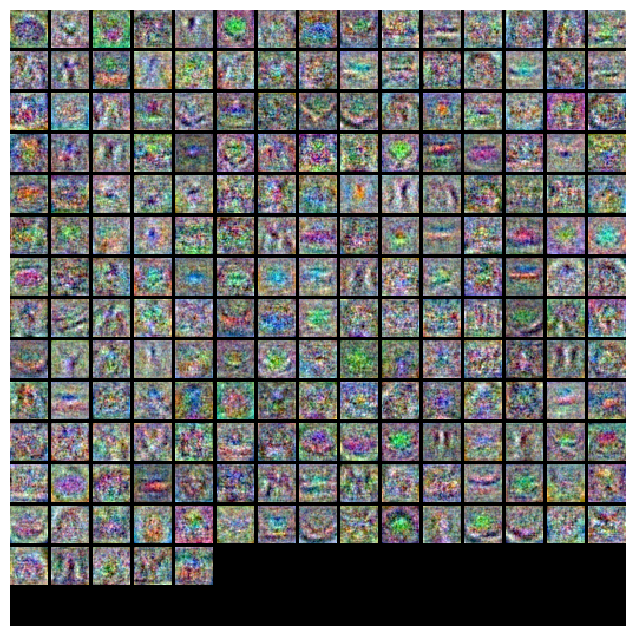

In [70]:
# weight 시각화

show_net_weights(best_model)

## Inline Question 2:

Now that you have trained a Neural Network classifier, you may find that your testing accuracy is much lower than the training accuracy. In what ways can we decrease this gap? Select all that apply.

1. Train on a larger dataset.
2. Add more hidden units.
3. Increase the regularization strength.
4. None of the above.

$\color{blue}{\textit Your Answer:}$ 1, 3

$\color{blue}{\textit Your Explanation:}$
1. 데이터셋을 늘리면 더 일반화된 패턴을 학습할 수 있기 때문에 training set에 overfitting 되는 정도를 줄일 수 있다.
2. hidden unit을 늘리면 모델이 더 복잡해져 training set에 overfitting 될 가능성이 오히려 높아진다.
3. regularization strength를 증가시키면 정규화가 일어나기 때문에 overfitting이 일어나는 것을 방지할 수 있다.

